## ScotiaBank

### Predict the price of gold at market close on Friday July 24, 2020.

### Data & Features

We collected data on daily gold prices from 1978 -2020. However, for the sake of this challenge, we decided to work with data from a shorter timeframe, from 03.07.2007 to 10.07.2020. 

### Acknowledgements :

1. Forecasting : Principles and Practise (Rob J Hyndman and George Athanasopoulos, Monash University, Australia) https://otexts.com/fpp2/

2. A Gentle Introduction to Time Series Forecasting in Python 
https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/


### Table of Contents

1. Initial Data Analysis (checking the trend, seasonal, residual components in the price data)
2. Checking stationarity of the time series
3. ACFand PACF plots to check for autocorrelation in the series
4. Choosing a model :

    a) Smoothing methods (Simple Exponential Smoothing, Holt's Smoothing, Damped Smoothing)
    
    b) Non seasonal ARIMA models

5. Final discussion and conclusion


#### Answer : The gold price at market close on 24th July 2020 to be 1810.646391 US dollars

Let us begin and see how I arrived at the above answer.

#### Importing Libraries and Initial Data Analysis

In [28]:
# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression

# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-darkgrid')

#datetime import
from datetime import datetime

#libraries for timeseries forecasting
import itertools
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.statespace.sarimax import SARIMAX

#scaling
from sklearn.preprocessing import MinMaxScaler

#Keras library for Recurrent neural network
#from keras.models import Sequential
#from keras.layers import LSTM, Dropout, Dense

import warnings
warnings.filterwarnings("ignore")

#We will import other libraries as necessary as we go forward

We will do time series analysis and make predictions (or forecast) on the gold price

In [29]:
#get the gold data
date_format = '%Y-%m-%d'
gold_price = pd.read_csv('gold_price.csv')
gold_price['Date'] = [datetime.strptime(i, date_format) for i in gold_price['Date']]

# get month of date and set date column as index
gold_price['month'] = gold_price['Date'].apply(lambda x: x.month)
gold_price.set_index('Date', inplace=True)
gold_price.head()

,Gold_Price,month
Date,,
2007-07-03,654.3,7
2007-07-04,654.2,7
2007-07-05,651.0,7
2007-07-06,648.8,7
2007-07-09,661.3,7


In [30]:
gold_price.tail()

,Gold_Price,month
Date,,
2020-07-06,"1,787.9",7
2020-07-07,"1,789.6",7
2020-07-08,"1,811.1",7
2020-07-09,"1,812.1",7
2020-07-10,"1,803.1",7


In [31]:
#convert the price to float
gold_price['Gold_Price'] = gold_price['Gold_Price'].str.replace(',', '').astype(float)

gold_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3399 entries, 2007-07-03 to 2020-07-10
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gold_Price  3399 non-null   float64
 1   month       3399 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 79.7 KB


In [32]:
print('Date ranges from {} to {}.'.format(min(gold_price.index), max(gold_price.index)))

Date ranges from 2007-07-03 00:00:00 to 2020-07-10 00:00:00.


#### Let us visualize the monthly gold prices over the years

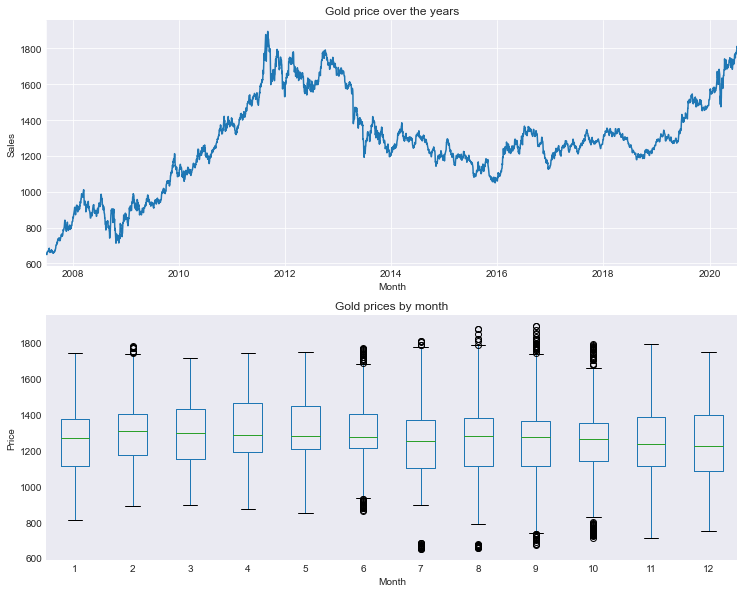

In [33]:
# visualize monthly furniture sales
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

gold_price['Gold_Price'].plot(ax=ax[0])
ax[0].set_title('Gold price over the years')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Sales')

gold_price.boxplot(column='Gold_Price', by='month', grid=False, ax=ax[1])
ax[1].set_title('Gold prices by month')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Price')
fig.suptitle('')
plt.show()

It seems like there was a great increasing trend til 2012 and then there is a decreasing trend from 2013 to 2016 and an increasing trend after that. The data overall seems very non-stationary apriori.

It also looks like gold prices are slightly higher in the months of February, March and April, but overall the mean price over the months do not vary much.


#### Stationarity is the property of exhibiting constant statistical properties (mean, variance, autocorrelation, etc.). If the mean of a time-series increases over time, then it’s not stationary.

Let us visualize the logarithm of the time series to see if that provides some more insight

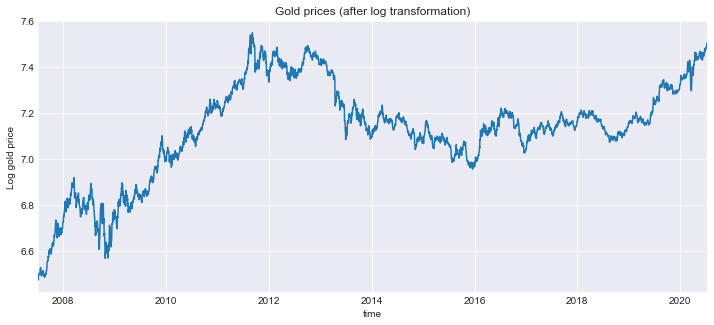

In [34]:
# visualize log transformed sales
gold_price['Gold_Price_log'] = np.log(gold_price['Gold_Price'])

fig, ax = plt.subplots(figsize=(12, 5))
gold_price['Gold_Price_log'].plot(ax=ax)
ax.set_title('Gold prices (after log transformation)')
ax.set_xlabel('time')
ax.set_ylabel('Log gold price')
plt.show()

Visually, log transformation does not seem to help in making the data stationary. But we will explore this further. Before going to that, let us now take a look at the different components of this time series : trend, seasonality and residuals.

### Decomposing the time series into the different components

Trend : A long-term increase or decrease in the data. This can be seen as a slope (is doesn’t have to be linear) roughly going through the data.

Seasonality : A time series is said to be seasonal when it is affected by seasonal factors (hour of day, week, month, year, etc.). Seasonality can be observed with nice cyclical patterns of fixed frequency.

Residuals : They are the difference between an observation and its predicted value at each time step. 

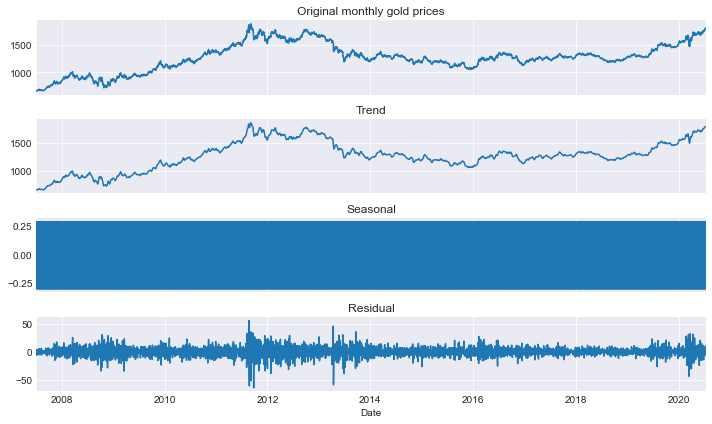

In [35]:
def plot_decomposition(ts, model):
    '''plots different components of time series data
       : original data, trend, seasonal, and residual
    '''
    decomposition = sm.tsa.seasonal_decompose(ts, model=model)
    
    fig, ax = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
    ts.plot(ax=ax[0])
    ax[0].set_title('Original monthly gold prices')
    decomposition.trend.plot(ax=ax[1])
    ax[1].set_title('Trend')
    decomposition.seasonal.plot(ax=ax[2])
    ax[2].set_title('Seasonal')
    decomposition.resid.plot(ax=ax[3])
    ax[3].set_title('Residual')
    plt.tight_layout()
    plt.show()
    
plot_decomposition(gold_price['Gold_Price'], 'additive')

### Checking stationarity

#### Plotting rolling statistics

Plotting rolling means and variances is a first good way to visually inspect our series. If the rolling statistics exhibit a clear trend (upwards or downwards) and show varying variance (increasing or decreasing amplitude), then I can conclude that the series is very likely not to be stationary.

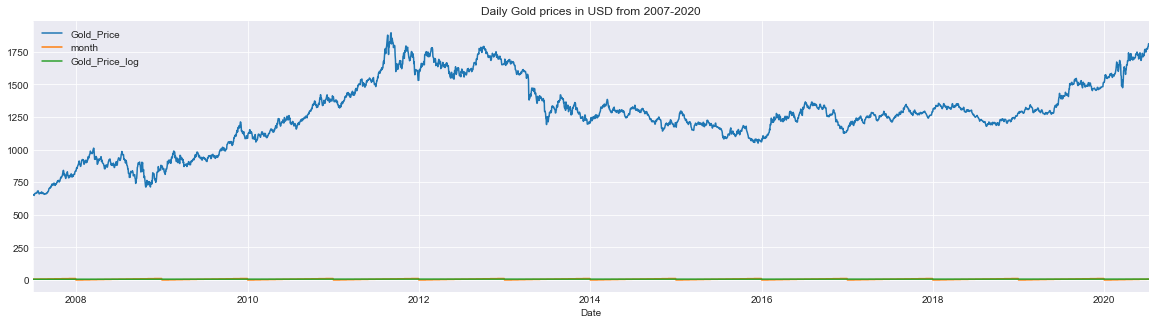

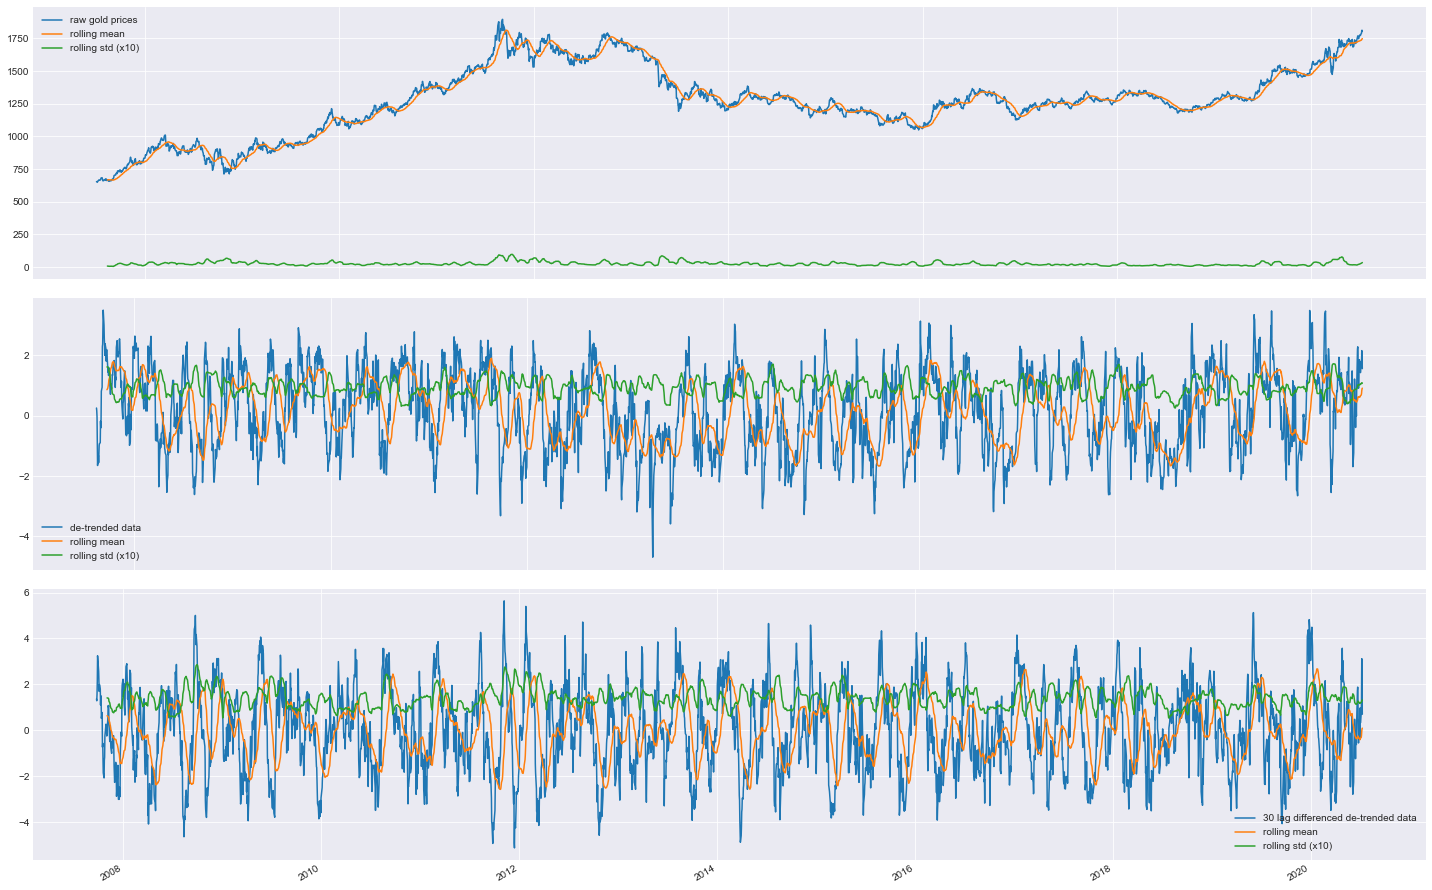

In [36]:
gold_price.plot(figsize=(20,5));
plt.title('Daily Gold prices in USD from 2007-2020');

gold_price['rolling_Gold_Price'] = (gold_price['Gold_Price'] - gold_price.Gold_Price.rolling(window=30).mean()) / gold_price.Gold_Price.rolling(window=30).std()
gold_price['rolling_price'] = gold_price['rolling_Gold_Price'] - gold_price['rolling_Gold_Price'].shift(30)

def plot_rolling(gold_price):
    fig, ax = plt.subplots(3,figsize=(20, 15))
    ax[0].plot(gold_price.index, gold_price.Gold_Price, label='raw gold prices')
    ax[0].plot(gold_price.Gold_Price.rolling(window=30).mean(), label="rolling mean");
    ax[0].plot(gold_price.Gold_Price.rolling(window=30).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(gold_price.index, gold_price.rolling_Gold_Price, label="de-trended data")
    ax[1].plot(gold_price.rolling_Gold_Price.rolling(window=30).mean(), label="rolling mean");
    ax[1].plot(gold_price.rolling_Gold_Price.rolling(window=30).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(gold_price.index, gold_price.rolling_price, label="30 lag differenced de-trended data")
    ax[2].plot(gold_price.rolling_price.rolling(window=30).mean(), label="rolling mean");
    ax[2].plot(gold_price.rolling_price.rolling(window=30).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()
    
plot_rolling(gold_price)

#### Augmented Dickey-Fuller Test

This test is used to assess whether or not a time-series is stationary. Without getting details about hypothesis testing, this test will give a result called a “test-statistic”, based on which we can say, with different levels (or percentage) of confidence, if the time-series is stationary or not.

In [37]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(gold_price.Gold_Price, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(gold_price.rolling_Gold_Price.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 30-lag differenced de-trended data stationary ?")
dftest = adfuller(gold_price.rolling_price.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -1.647
P-value = 0.458
Critical values :
	1%: -3.432289621245231 - The data is not stationary with 99% confidence
	5%: -2.862397011976169 - The data is not stationary with 95% confidence
	10%: -2.5672262040731995 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -10.704
P-value = 0.000
Critical values :
	1%: -3.4323000324316353 - The data is  stationary with 99% confidence
	5%: -2.862401610600734 - The data is  stationary with 95% confidence
	10%: -2.5672286522670866 - The data is  stationary with 90% confidence

 > Is the 30-lag differenced de-trended data stationary ?
Test statistic = -16.316
P-value = 0.000
Critical values :
	1%: -3.4323271536402444 - The data is  stationary with 99% confidence
	5%: -2.862413589972406 - The data is  stationary with 95% confidence
	10%: -2.5672350298007505 - The data is  stationary with 90% confidence


This tells us that the data itself is not stationary. Let us explore a bit further here.

#### Auto correlation plots : ACF and PACF

An autocorrelation (ACF) plot represents the autocorrelation of the series with lags of itself.


A partial autocorrelation (PACF) plot represents the amount of correlation between a series and a lag of itself that is not explained by correlations at all lower-order lags.
Ideally, we want no correlation between the series and lags of itself. Graphically speaking, we would like all the spikes to fall in the blue region.


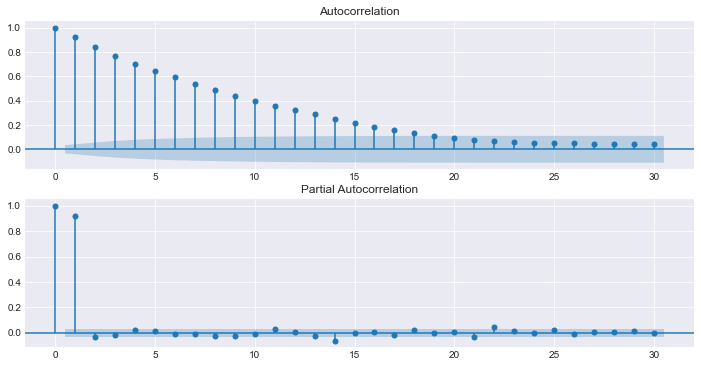

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(gold_price.rolling_Gold_Price.dropna(), ax=ax[0], lags=30)
ax[1] = plot_pacf(gold_price.rolling_Gold_Price.dropna(), ax=ax[1], lags=30)

As we can see, there are several spikes above the blue region, meaning there are correlations at lags 1 to 18. The spikes in the ACF plot decrease very fast (almost exponentially).

Also, there is a significant spike at lag 1 in the PACF, but none beyond lag 1.
 .

### Choosing a model

#### Exponential smoothings #### 
These methods are appropriate for non-stationary data.

#### ARIMA ####
These models should be used on stationary data only. One should therefore remove the trend of the data (via deflating or logging), and then look at the differenced series.

#### Smoothing methods :

Smoothing methods work as weighted averages. Forecasts are weighted averages of past observations. The weights can be uniform (this is a moving average), or following an exponential decay — this means giving more weight to recent observations and less weight to old observations. More advanced methods include other parts in the forecast, like seasonal components and trend components. Our data does not have a seasonal component so we do not need to worry about that part.

In [141]:
df = pd.DataFrame(gold_price, columns=['Gold_Price'])
df.head()

,Gold_Price
Date,
2007-07-03,654.3
2007-07-04,654.2
2007-07-05,651.0
2007-07-06,648.8
2007-07-09,661.3


Now we split our data into the train and test sets with the last 90 rows of data being the test set.

In [155]:
# Taking last 90 rows of data to be validation set
train = df.iloc[:-10, :]
test = df.iloc[-10:-1, :]
pred = test.copy()

test.head(2)

,Gold_Price
Date,
2020-06-29,1771.6
2020-06-30,1768.1


So we are using gold prices from 09 March as data to test on.

#### Simple Exponential Smoothing

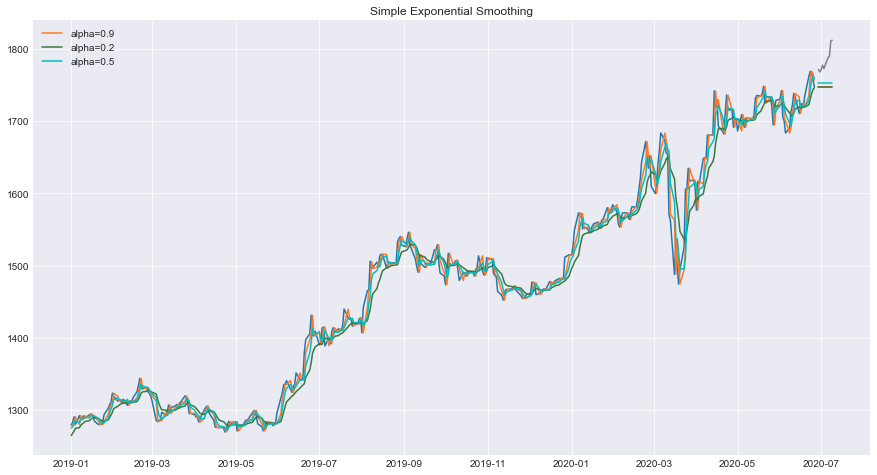

In [149]:
#Since we do not have a clear trend or seasonality, let us fit a Simple exponential smoothing model.
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

model = SimpleExpSmoothing(np.asarray(train['Gold_Price']))
#model._index = pd.to_datetime(train.index)

#Here we run three variants of simple exponential smoothing:

fit1 = model.fit()
pred1 = fit1.forecast(9)
fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(9)
fit3 = model.fit(smoothing_level=.5)
pred3 = fit3.forecast(9)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(train.index[3000:], train.values[3000:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[3000:], f.fittedvalues[3000:], color=c)
    ax.plot(test.index, p, label="alpha=" + str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend();

Since there is a somewhat increasing non-linear trend over the years, let us try Holt's exponential smoothing here.  

#### Holt's Exponential Smoothing

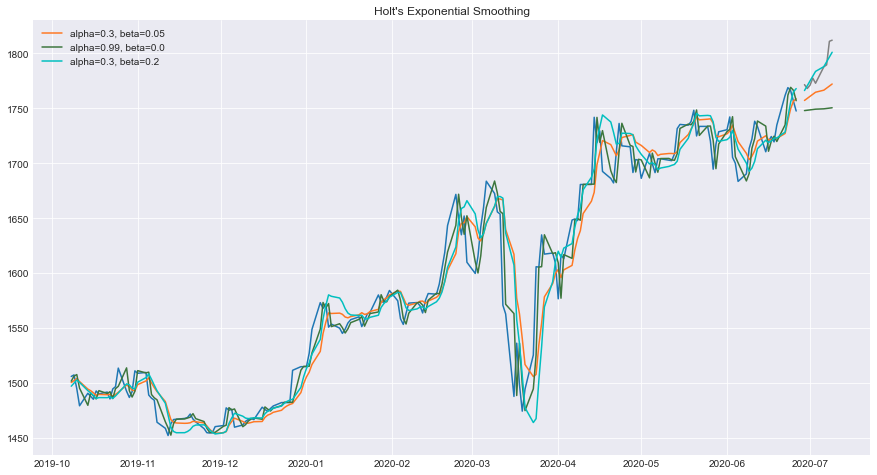

In [151]:
model_h = Holt(np.asarray(train['Gold_Price']))
#model._index = pd.to_datetime(train.index)

#Here we run three variants of Holt's exponential smoothing

fit1 = model_h.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(9)
fit2 = model_h.fit(optimized=True)
pred2 = fit2.forecast(9)
fit3 = model_h.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(9)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(train.index[3200:], train.values[3200:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[3200:], f.fittedvalues[3200:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")    
plt.legend();

In fit2 above in Holt's smotthing, we use the auto optimization that allow statsmodels to automatically find an optimized value for us.
In fit3, for alpha = 0.3, beta =0.2, the result seems comparable to the actual prices. That seems to be performing better than the other two.

The problem with Holt’s Linear trend method is that the trend is constant in the future, increasing or decreasing indefinitely. For long forecast horizons, this can be problematic. The damped trend method is therefore a method which add a dampening parameter so that the trend converges to a constant value in the future (it flattens the trend).

#### Holt’s Damped Trend

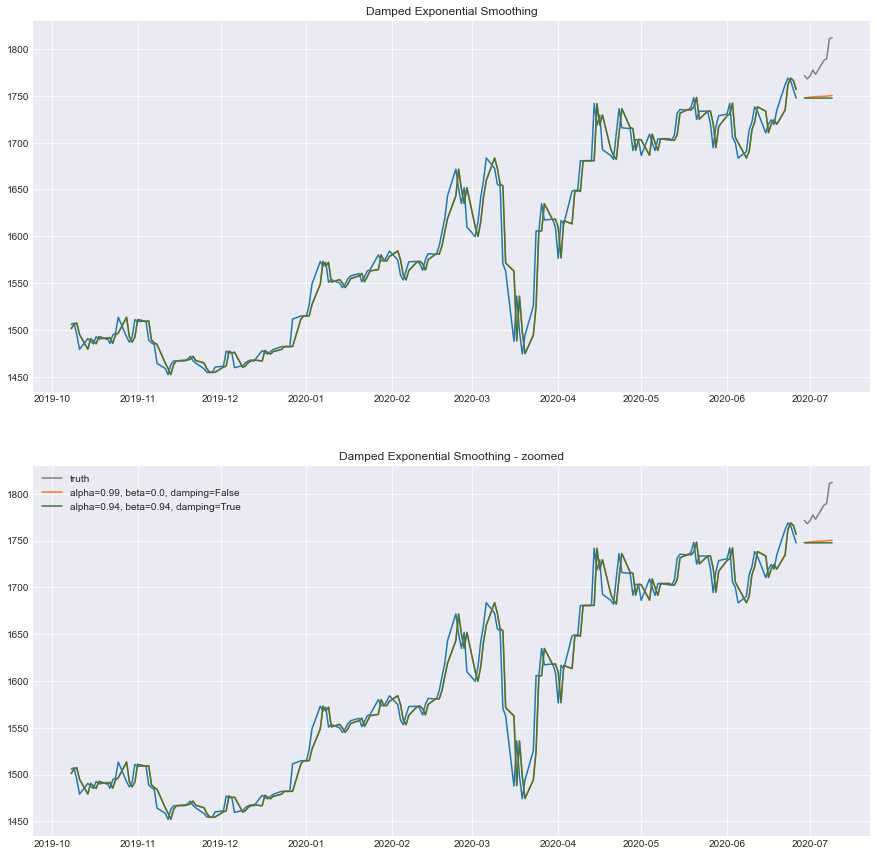

In [153]:
#Let us fit two models, one with a multiplicative trend but no damping, ther one with dampening.
#Data has a trend. Use the multiplicative trend, since the data has not been logged before. 
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(np.asarray(train['Gold_Price']), trend='mul', seasonal=None)
model2 = ExponentialSmoothing(np.asarray(train['Gold_Price']), trend='mul', seasonal=None, damped = True)

#Here we run three variants of simple exponential smoothing:

fit1 = model.fit()
pred1 = fit1.forecast(9)
fit2 = model2.fit()
pred2 = fit2.forecast(9)


fig, ax = plt.subplots(2, figsize=(15, 15))
ax[0].plot(train.index[3200:], train.values[3200:])
ax[0].plot(test.index, test.values, color="gray", label = 'truth')
ax[1].plot(train.index[3200:], train.values[3200:])
ax[1].plot(test.index, test.values, color="gray", label = 'truth')

for p, f, c in zip((pred1, pred2),(fit1, fit2),('#ff7823','#3c763d')):
    ax[0].plot(train.index[3200:], f.fittedvalues[3200:], color=c)
    ax[1].plot(train.index[3200:], f.fittedvalues[3200:], color=c)
    ax[0].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4]+ ", damping="+str(True if f.params['damping_slope']>0 else False), color=c)
    ax[1].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4]+ ", damping="+str(True if f.params['damping_slope']>0 else False), color=c)
ax[0].set_title("Damped Exponential Smoothing");
ax[1].set_title("Damped Exponential Smoothing - zoomed");
plt.legend();

Damped predictions do not really compare well to the actual prices.

### ARIMA models

ARIMA models are a general class of models to forecast stationary time series. ARIMA models are made of three parts:

1. A weighted sum of lagged values of the series (Auto-regressive (AR) part)
2. A weighted sum of lagged forecasted errors of the series (Moving-average (MA) part)
3. A difference of the time series (Integrated (I) part)

An ARIMA model is often noted ARIMA(p, d, q) where p represents the order of the AR part, d the order of differencing (“I” part), and q the order of the MA term.

The first step of fitting an ARIMA model is to determine the differencing order to stationarize the series. Before that, clearly, the gold prices data isnot stationary. Let us do a KPSS test on the logged gold prices to see if that data is stationary.

In [45]:
from statsmodels.tsa.stattools import kpss

print(" > Is the data stationary ?")
dftest = kpss(np.log(gold_price.Gold_Price), 'ct')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[3].items():
    print("\t{}: {}".format(k, v))

 > Is the data stationary ?
Test statistic = 1.593
P-value = 0.010
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


Since the test statistic is bigger than the critical values, the gold prices data is not trend stationary.

Hence let us try differencing after taking the logarithm, to make the time series stationary and see if that works.

<AxesSubplot:xlabel='Date'>

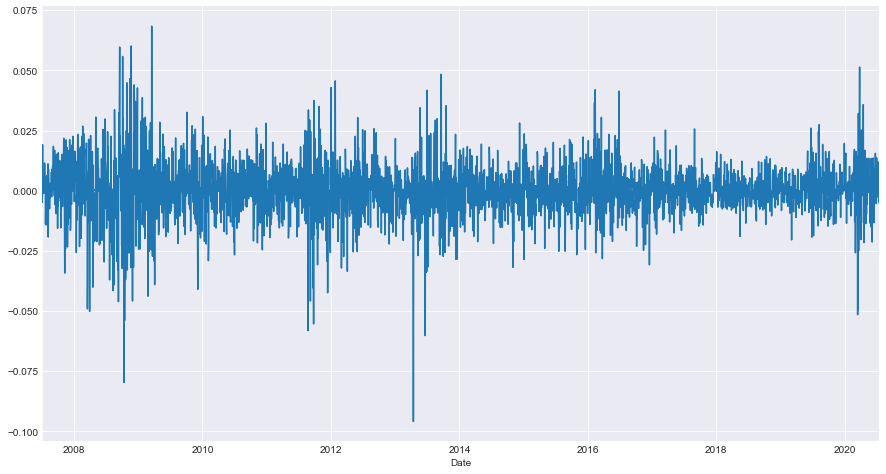

In [48]:
gold_price['Gold_Price_log'] = np.log(gold_price['Gold_Price'])
gold_price['Gold_Price_log_diff'] = gold_price['Gold_Price_log'] - gold_price['Gold_Price_log'].shift(1)

fig, ax = plt.subplots(figsize=(15, 8))
gold_price['Gold_Price_log_diff'].dropna().plot()

We see a significant improvement here and it seems this data could be stationary. Let us do a quick KPSS test to check if the visual intuition is correct.

In [49]:
from statsmodels.tsa.stattools import kpss

print(" > Is the data stationary ?")
dftest_d = kpss(gold_price['Gold_Price_log_diff'].dropna(), 'ct')
print("Test statistic = {:.3f}".format(dftest_d[0]))
print("P-value = {:.3f}".format(dftest_d[1]))
print("Critical values :")
for k, v in dftest_d[3].items():
    print("\t{}: {}".format(k, v))

 > Is the data stationary ?
Test statistic = 0.170
P-value = 0.030
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


The test statistic is less than the critical value. This suggests the logged differenced gold prices are stationary. Let us take a quick look at the ACF and PACF plots here.

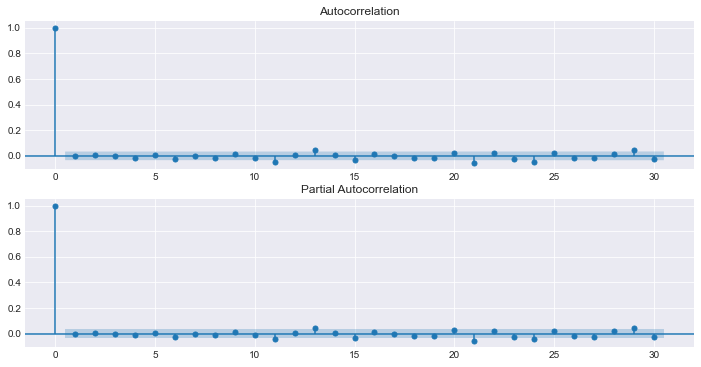

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(gold_price.Gold_Price_log_diff.dropna(), ax=ax[0], lags=30)
ax[1] = plot_pacf(gold_price.Gold_Price_log_diff.dropna(), ax=ax[1], lags=30)

Since the autocorrelations are all very small and patternless from lag 1 onwards, there is no need of higher order differencing after this. Still, let’s check our results by comparing a (0, 0, 0) and a (0, 1, 0) ARIMA model:

                              ARMA Model Results                              
Dep. Variable:             Gold_Price   No. Observations:                 3399
Model:                     ARMA(0, 0)   Log Likelihood                 395.303
Method:                           css   S.D. of innovations              0.215
Date:                Tue, 21 Jul 2020   AIC                           -786.606
Time:                        08:25:47   BIC                           -774.344
Sample:                    07-03-2007   HQIC                          -782.224
                         - 07-10-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1249      0.004   1928.414      0.000       7.118       7.132
                             ARIMA Model Results                              
Dep. Variable:           D.Gold_Price   No. Observat

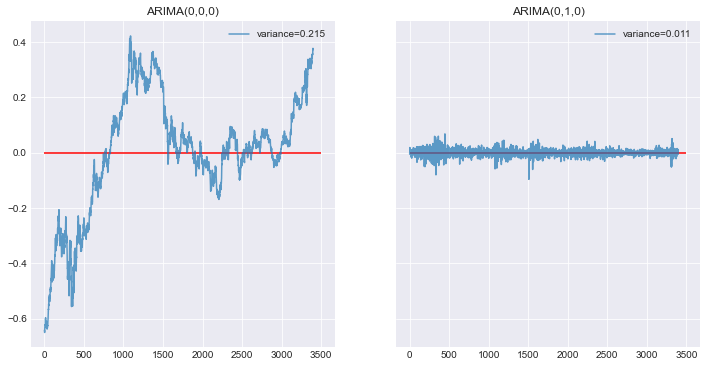

In [54]:
from statsmodels.tsa.arima_model import ARIMA

model_a1 = ARIMA(np.log(gold_price.Gold_Price).dropna(), (0, 0, 0))
res_000 = model_a1.fit()
print(res_000.summary())

model_a2 = ARIMA(np.log(gold_price.Gold_Price).dropna(), (0, 1, 0))
res_010 = model_a2.fit()
print(res_010.summary())


fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=3500, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=3500, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

AIC is much smaller with the ARIMA (0,1,0) model showing this model is performing better than ARIMA(0,0,0).

Now we know we have to include a 1st order difference in our model, we need to choose the Moving-Average order. This is done by looking at the differenced series (because we just saw that the first-order difference series was stationary). Again, we look at our ACF and PACF plots, with this rule in mind:

“ If the lag-1 autocorrelation of the differenced series ACF is negative, and/or there is a sharp cutoff, then choose a MA order of 1”. In our logged difference ACF, this is not the case. 

What about the AR (auto regression) term? Should we add it at all ? I believe it is no. In fact, we should add an AR term in the case where :

“ If the lag-1 autocorrelation of the differenced series PACF is negative, and/or there is a sharp cutoff, then choose a AR order of 1”.

Just to be sure, let us still fit two more ARIMA models one ARIMA (1, 1, 0) and ARIMA (1, 1, 1).

                             ARIMA Model Results                              
Dep. Variable:           D.Gold_Price   No. Observations:                 3398
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10444.038
Method:                       css-mle   S.D. of innovations              0.011
Date:                Tue, 21 Jul 2020   AIC                         -20882.076
Time:                        08:42:54   BIC                         -20863.683
Sample:                    07-04-2007   HQIC                        -20875.502
                         - 07-10-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0003      0.000      1.560      0.119   -7.66e-05       0.001
ar.L1.D.Gold_Price    -0.0038      0.017     -0.222      0.824      -0.037       0.030
                    

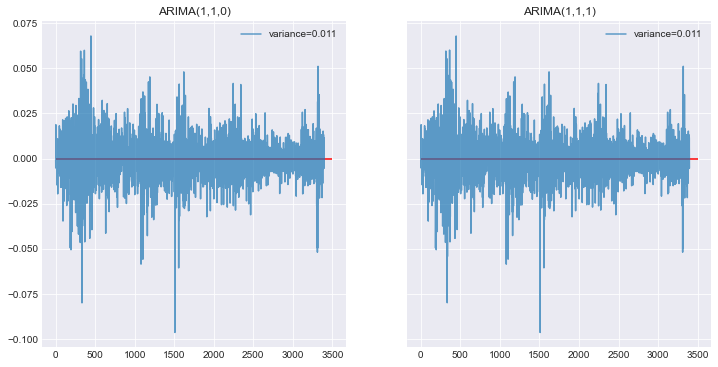

In [55]:
model_a3 = ARIMA(np.log(gold_price.Gold_Price).dropna(), (1, 1, 0))
res_110 = model_a3.fit()
print(res_110.summary())


#let us stick check by adding AR term as 1.
model_a4 = ARIMA(np.log(gold_price.Gold_Price).dropna(), (1, 1, 1))
res_111 = model_a4.fit()
print(res_111.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_110.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_110.resid.values)));
ax[0].hlines(0, xmin=0, xmax=3500, color='r');
ax[0].set_title("ARIMA(1,1,0)");
ax[0].legend();
ax[1].plot(res_111.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_111.resid.values)));
ax[1].hlines(0, xmin=0, xmax=3500, color='r');
ax[1].set_title("ARIMA(1,1,1)");
ax[1].legend();

Indeed, we see that adding AR term and MA term do not further reduce the AIC score and the variance does not improve significantly either. So we choose (0, 1, 0) ARIMA  model as the solution model amongst the ARIMA models.

### Plotting predictions

Let us now plot the predictions from the ARIMA (0, 1, 0) model.

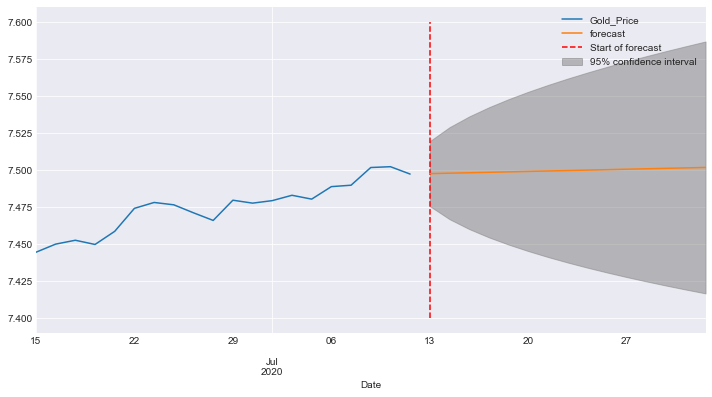

In [130]:
model_a2 = ARIMA(np.log(gold_price.Gold_Price).dropna(), (0, 1, 0))
res_010 = model_a2.fit()

fig, ax = plt.subplots(figsize=(12, 6))
np.log(gold_price.Gold_Price).dropna()[-20 : ].plot(ax=ax);
ax.vlines('2020-07-11', 7.4, 7.6, linestyle='--', color='r', label='Start of forecast');

# - NOTE from the official documentation :
# -- The dynamic keyword affects in-sample prediction. 
# -- If dynamic is False, then the in-sample lagged values are used for prediction. 
# -- If dynamic is True, then in-sample forecasts are used in place of lagged dependent variables.
ax = res_010.plot_predict('2020-07-11', '2020-07-31', dynamic=True, plot_insample=False, ax=ax);

In [131]:
days = pd.date_range('2020-07-11', '2020-07-31')
pred = np.exp(res_010.forecast(steps = 21)[0])
predictions = pd.DataFrame({'Date' : days, 'Prediction' : pred})
predictions.set_index('Date')

,Prediction
Date,
2020-07-11,1803.637983
2020-07-12,1804.176127
2020-07-13,1804.714432
2020-07-14,1805.252897
2020-07-15,1805.791522
2020-07-16,1806.330309
2020-07-17,1806.869256
2020-07-18,1807.408364
2020-07-19,1807.947633


Now let us compare the predictions till 21-07-2020 with the actual gold prices

In [137]:
test = pd.read_csv('test.csv')
test['Date'] = [datetime.strptime(i, date_format) for i in test['Date']]
test.set_index('Date')
merged_test = pd.merge(predictions, test)
merged_test

,Date,Prediction,Actual_Price
0,2020-07-13,1804.714432,1802.60
1,2020-07-14,1805.252897,1809.60
2,2020-07-15,1805.791522,1813.16
3,2020-07-16,1806.330309,1798.45
4,2020-07-17,1806.869256,1810.01
5,2020-07-20,1808.487062,1818.26
6,2020-07-21,1809.026653,1838.68


In [139]:
def get_rmse(actual, predicted):
    return np.mean((predicted - actual)**2)**.5

rmse_arima = get_rmse(merged_test['Actual_Price'].values, merged_test['Prediction'])
print('RMSE of SARIMA forecast: {0:.4f}'.format(rmse_arima))

RMSE of SARIMA forecast: 12.6743


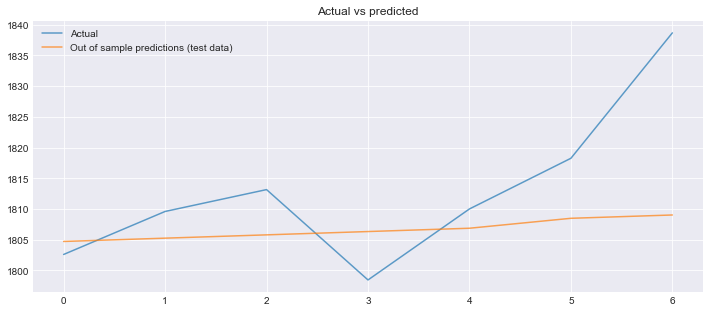

In [140]:
fig, ax = plt.subplots(figsize=(12, 5))
merged_test['Actual_Price'].plot(ax=ax, label='Actual', alpha=.7)
merged_test['Prediction'].plot(ax=ax, label='Out of sample predictions (test data)', alpha=.7)
ax.set_title('Actual vs predicted')
plt.legend()
plt.show()

#### Plotting predictions from smoothing model

Recall amongst the smoothing models, the forecasts from Holt's exponential smoothing process with parameters, alpha = 0.2 and beta = 0.3 seemed to line up well with the actual prices.

Let us calculate the RMSE and plot the predictions from this model. 

In [159]:
days = pd.date_range('2020-06-29', '2020-07-31')
pred_1 = fit3.forecast(33)
predictions_1 = pd.DataFrame({'Date' : days, 'Prediction_holt_smoothing' : pred_1})
predictions_1.set_index('Date')

,Prediction_holt_smoothing
Date,
2020-06-29,1766.258395
2020-06-30,1770.614464
2020-07-01,1774.970533
2020-07-02,1779.326602
2020-07-03,1783.682672
2020-07-04,1788.038741
2020-07-05,1792.394810
2020-07-06,1796.750879
2020-07-07,1801.106948


In [167]:
test_price = pd.read_csv('test.csv')
test_price['Date'] = [datetime.strptime(i, date_format) for i in test_price['Date']]
test_price.set_index('Date')
merged_test_holt = pd.merge(predictions_1, test_price)
merged_test_holt

,Date,Prediction_holt_smoothing,Actual_Price
0,2020-07-13,1827.243363,1802.60
1,2020-07-14,1831.599432,1809.60
2,2020-07-15,1835.955501,1813.16
3,2020-07-16,1840.311571,1798.45
4,2020-07-17,1844.667640,1810.01
5,2020-07-20,1857.735847,1818.26
6,2020-07-21,1862.091916,1838.68


In [168]:
#Calculating the RMSE of the model

rmse_holt = get_rmse(merged_test_holt['Actual_Price'].values, merged_test_holt['Prediction_holt_smoothing'])
print('RMSE of SARIMA forecast: {0:.4f}'.format(rmse_holt))

RMSE of SARIMA forecast: 30.8705


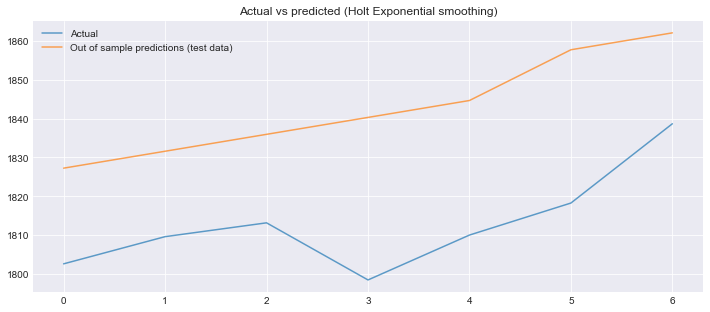

In [170]:
fig, ax = plt.subplots(figsize=(12, 5))
merged_test_holt['Actual_Price'].plot(ax=ax, label='Actual', alpha=.7)
merged_test_holt['Prediction_holt_smoothing'].plot(ax=ax, label='Out of sample predictions (test data)', alpha=.7)
ax.set_title('Actual vs predicted (Holt Exponential smoothing)')
plt.legend()
plt.show()

### Conclusion

It seems that the predictions from the ARIMA (0,1,0) model was more reliable. That model shows a root mean squared error of 12.67 whereas the Holt's exponential smoothing model has RMSE 30.87. 

This is likely due to the fact that the exponential smoothing model takes into account the increasing trend and even though in the short run, it showed promising results, its predictions shoot up quite a bit as time passes and it does not reflect the original price.

#### Hence, regarding the question that need to be answered, we choose the prediction of the gold price from the ARIMA(0, 1, 0) model as our final answer.

#### We forecast that the gold price at market close on 24th July 2020 to be 1810.646391 US dollars.


Note : Couple of things to keep in mind here.

1. Since 24th of July is Friday, last working day of any week, one could have also worked with weekly gold prices. An advantage to that would have been that out model would not be predicting gold prices for Saturdays and Sundays(which it is doing in this case). However, we decided to work with daily prices since this way, our model will have more data to learn from.

2. I could have just trained multiple ARIMA models directly using grid search and compared AIC scores directly to conclude which one works best. However, I have used this problem as a starting point to learn and study time series forecasting for the first time. Taking it one step at a time and understanding this time series analysis was, according to me, teh right way to go.

3. I also had another approach to solving this problem. In that approach, I treated the problem as a multiple linear regression problem , where we predict gold prices based on many other factors like S&P index, US Dollar exchange rate, other metal's prices and a couple of technical indicators. We decided to not take that as our final approach because the list of such features is not exhaustive, and gathering data on a somewhat exhaustive list is quite a big problem for a short project like this. In any case ARIMA models give much better predictions of gold prices as compared to a regression technique.

4. Another possible approach to this problem would be to explore the gold prices data via recurrent neural networks (LSTMs). This we relay to future work.


